In [ ]:
## Loading libraries
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from collections import Counter
import time
import sys
import psutil
import gc

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
## Setting paths
base_dir  = os.path.join('/content/drive', 'My Drive/ML_Colab')
data_dir = os.path.join(base_dir, 'Data')
fp_cleaned_data = os.path.join(data_dir, '1.2_data_cleaned.pkl')

In [ ]:
### CONFIGURATIONs ###
rs = 7                  # random seed
data_frac = 1.0         # subset of whole data to use
reduction_rate = 0.33   # percentage of features to reduce the dim. to (greater rate ~ more features to select)
transformer_rate = 0.25 # percentage of samples for fitting to svd transformer

### Loading Data:

In [ ]:
## Loading data
%%time
with open(fp_cleaned_data, 'rb') as f:
    data = pickle.load(f)
    print(data.shape)

(2125056, 13)
CPU times: user 5 s, sys: 2.67 s, total: 7.66 s
Wall time: 10.5 s


In [ ]:
## only keeping required columns and dropping the rest
data = data[['txt_clean', 'star']]
data.head(3)

,txt_clean,star
0,奥创 都 知道 整容 去 韩国,3
1,非常 失望 剧本 完全 敷衍了事 主线 剧情 没 突破 大家 理解 所有 人物 都 缺乏 动...,2
2,2015 年度 最 失望 作品 以为 面面俱到 实则 画蛇添足 以为 主题深刻 实则 老调重...,2


In [ ]:
%%time
data['w_count'] = data['txt_clean'].apply(lambda x: len(x.split()))

CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 2.45 s


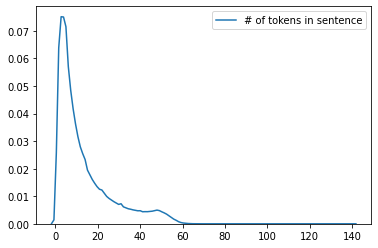

In [ ]:
sns.kdeplot(data['w_count'], label='# of tokens in sentence')
plt.show()

In [ ]:
c = len(data[(data['w_count'] < 2) | (data['w_count'] > 80)])
print(f"There are {c} samples which have less than 2 tokens or more than 80 tokens.")

There are 122444 samples which have less than 2 tokens or more than 80 tokens.


In [ ]:
## Dropping samples with less than 2 tokens or more than 80 tokens
data.drop(data[(data['w_count'] < 2) | (data['w_count'] > 80)].index, inplace=True)
data.shape

(2002612, 3)

In [ ]:
data.head()

,txt_clean,star,w_count
0,奥创 都 知道 整容 去 韩国,3,6
1,非常 失望 剧本 完全 敷衍了事 主线 剧情 没 突破 大家 理解 所有 人物 都 缺乏 动...,2,54
2,2015 年度 最 失望 作品 以为 面面俱到 实则 画蛇添足 以为 主题深刻 实则 老调重...,2,42
3,铁人 2 中 勾引 钢铁 侠 妇联 1 中 勾引 鹰眼 美队 2 中 勾引 美国 队长 妇联...,4,45
4,从头 打到 尾 真的 很 无聊,2,6


In [ ]:
%%time
## Shuffle the data and select a subset of data defined by 'data_frac' var
_data = data.sample(frac=data_frac, random_state=rs)

## Splitting into train, validation and test sets
X, test_txt, Y, test_lb = train_test_split(_data['txt_clean'], 
                                            _data['star'].values, 
                                            train_size=0.7,
                                            test_size=0.3, 
                                            random_state=rs, 
                                            stratify=_data['star'])


train_txt, valid_txt, train_lb, valid_lb = train_test_split(X, 
                                                            Y, 
                                                            train_size=0.8,
                                                            test_size=0.2, 
                                                            random_state=rs, 
                                                            stratify=Y)


print('Train Shapes:', train_txt.shape, train_lb.shape)
print('Valid Shapes:', valid_txt.shape, valid_lb.shape)
print('Test  Shapes:', test_txt.shape, test_lb.shape)

Train Shapes: (1121462,) (1121462,)
Valid Shapes: (280366,) (280366,)
Test  Shapes: (600784,) (600784,)
CPU times: user 2.84 s, sys: 25.5 ms, total: 2.87 s
Wall time: 2.87 s


### Vectorization:

In [ ]:
## Vectorize the clean text
%%time
tf_vect = TfidfVectorizer(min_df=0.0005, max_features=5000)
X_train_txt_sparse = tf_vect.fit_transform(train_txt)
X_valid_txt_sparse = tf_vect.transform(valid_txt)
X_test_txt_sparse = tf_vect.transform(test_txt)

print('Train, Valid, Test Shapes:', X_train_txt_sparse.shape, X_valid_txt_sparse.shape, X_test_txt_sparse.shape, '\n')

Train, Valid, Test Shapes: (1121462, 2728) (280366, 2728) (600784, 2728) 

CPU times: user 24.5 s, sys: 130 ms, total: 24.7 s
Wall time: 24.7 s


In [ ]:
# size = (sys.getsizeof(_data) + sys.getsizeof(data) + sys.getsizeof(train_txt) + sys.getsizeof(test_txt)) // 1e+6
# del _data, data, train_txt, test_txt
# print(f'{size} MB released from memory')

### Reducing dimension via feature selection (chi2):

In [ ]:
## Number of columns (features) to select
ft_count = round(X_train_txt_sparse.shape[1] * reduction_rate)
## Number of rows for fitting TruncatedSVD transformer
t_count = round(X_train_txt_sparse.shape[0] * transformer_rate)

In [ ]:
ft_count

900

In [ ]:
ch2 = SelectKBest(chi2, k=ft_count)

In [ ]:
%%time
X_train_txt_chi2 = ch2.fit_transform(X=X_train_txt_sparse, y=train_lb)
X_valid_txt_chi2 = ch2.transform(X=X_valid_txt_sparse)
X_test_txt_chi2 = ch2.transform(X=X_test_txt_sparse)

print('Train set shape after chi2:', X_train_txt_chi2.shape)
print('Valid set shape after chi2:', X_valid_txt_chi2.shape)
print('Test  set shape after chi2:', X_test_txt_chi2.shape, '\n')

Train set shape after chi2: (1121462, 900)
Valid set shape after chi2: (280366, 900)
Test  set shape after chi2: (600784, 900) 

CPU times: user 549 ms, sys: 2.85 ms, total: 552 ms
Wall time: 552 ms


## Comparing ML models performance:

### Multi-Class Classification:

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(C=1.0, n_jobs=-1, random_state=rs),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(),
    'SGDClassifier': SGDClassifier(n_jobs=-1, random_state=rs),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=rs, learning_rate=0.5)
}

In [ ]:
%%time
## Model: SGDClassifier
## Dataset: Non-Reduced dimension
## Type: Multi-Class Classification

sgd = models['SGDClassifier']
sgd.fit(X_train_txt_sparse, train_lb);
y_valid = sgd.predict(X_valid_txt_sparse)
y_pred = sgd.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nSGDClassifier Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

SGDClassifier Accuracy (Non-Reduced Dim.): 0.4465

Valid set report:
              precision    recall  f1-score   support

           1       0.43      0.50      0.46     24343
           2       0.29      0.11      0.16     23620
           3       0.44      0.34      0.38     63119
           4       0.44      0.27      0.33     85848
           5       0.47      0.79      0.59     83436

    accuracy                           0.45    280366
   macro avg       0.41      0.40      0.39    280366
weighted avg       0.43      0.45      0.42    280366

Test set report:
              precision    recall  f1-score   support

           1       0.43      0.49      0.46     52162
           2       0.30      0.11      0.16     50615
           3       0.44      0.33      0.38    135254
           4       0.44      0.27      0.33    183961
           5       0.47      0.79      0.59    178792

 

In [ ]:
%%time
## Model: SGDClassifier
## Dataset: Reduced dimension
## Type: Multi-Class Classification

sgd = models['SGDClassifier']
sgd.fit(X_train_txt_chi2, train_lb);
y_valid = sgd.predict(X_valid_txt_chi2)
y_pred = sgd.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nSGDClassifier Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

SGDClassifier Accuracy (Reduced Dim.): 0.4366

Valid set report:
              precision    recall  f1-score   support

           1       0.41      0.49      0.45     24343
           2       0.30      0.11      0.16     23620
           3       0.43      0.33      0.37     63119
           4       0.45      0.24      0.32     85848
           5       0.45      0.80      0.57     83436

    accuracy                           0.44    280366
   macro avg       0.41      0.39      0.37    280366
weighted avg       0.43      0.44      0.40    280366

Test set report:
              precision    recall  f1-score   support

           1       0.41      0.48      0.44     52162
           2       0.30      0.12      0.17     50615
           3       0.43      0.32      0.37    135254
           4       0.45      0.24      0.32    183961
           5       0.45      0.80      0.57    178792

    accu

In [ ]:
## Model: LogisticRegression
## Dataset: Non-Reduced dimension
## Type: Multi-Class Classification
%%time
lreg = models['LogisticRegression']
lreg.fit(X_train_txt_sparse, train_lb);
y_valid = lreg.predict(X_valid_txt_sparse)
y_pred = lreg.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nLogisticRegression Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

LogisticRegression Accuracy (Non-Reduced Dim.): 0.4854

Valid set report:
              precision    recall  f1-score   support

           1       0.51      0.48      0.49     24343
           2       0.41      0.14      0.21     23620
           3       0.44      0.43      0.43     63119
           4       0.44      0.51      0.47     85848
           5       0.57      0.60      0.59     83436

    accuracy                           0.49    280366
   macro avg       0.47      0.43      0.44    280366
weighted avg       0.48      0.49      0.48    280366

Test set report:
              precision    recall  f1-score   support

           1       0.50      0.47      0.49     52162
           2       0.41      0.14      0.21     50615
           3       0.44      0.42      0.43    135254
           4       0.44      0.51      0.47    183961
           5       0.57      0.60      0.59    1787

In [ ]:
%%time
## Model: LogisticRegression
## Dataset: Reduced dimension
## Type: Multi-Class Classification
lreg = models['LogisticRegression']
lreg.fit(X_train_txt_chi2, train_lb);
y_valid = lreg.predict(X_valid_txt_chi2)
y_pred = lreg.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nLogisticRegression Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

LogisticRegression Accuracy (Reduced Dim.): 0.4744

Valid set report:
              precision    recall  f1-score   support

           1       0.50      0.45      0.48     24343
           2       0.42      0.12      0.19     23620
           3       0.44      0.39      0.41     63119
           4       0.42      0.53      0.47     85848
           5       0.56      0.59      0.57     83436

    accuracy                           0.47    280366
   macro avg       0.47      0.42      0.42    280366
weighted avg       0.47      0.47      0.47    280366

Test set report:
              precision    recall  f1-score   support

           1       0.50      0.45      0.47     52162
           2       0.42      0.12      0.19     50615
           3       0.44      0.39      0.41    135254
           4       0.42      0.53      0.47    183961
           5       0.56      0.59      0.57    178792

   

In [ ]:
%%time
## Model: SVM ~ LinearSVC
## Dataset: Non-Reduced dimension
## Type: Multi-Class Classification
lsvc = models['LinearSVC']
lsvc.fit(X_train_txt_sparse, train_lb);
y_valid = lsvc.predict(X_valid_txt_sparse)
y_pred = lsvc.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nLinearSVC Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

LinearSVC Accuracy (Non-Reduced Dim.): 0.4832

Valid set report:
              precision    recall  f1-score   support

           1       0.50      0.49      0.49     24343
           2       0.48      0.08      0.13     23620
           3       0.44      0.41      0.43     63119
           4       0.44      0.50      0.47     85848
           5       0.54      0.64      0.59     83436

    accuracy                           0.48    280366
   macro avg       0.48      0.42      0.42    280366
weighted avg       0.48      0.48      0.47    280366

Test set report:
              precision    recall  f1-score   support

           1       0.50      0.48      0.49     52162
           2       0.49      0.08      0.14     50615
           3       0.44      0.41      0.43    135254
           4       0.44      0.50      0.47    183961
           5       0.54      0.64      0.59    178792

    a

In [ ]:
%%time
## Model: SVM ~ LinearSVC
## Dataset: Reduced dimension
## Type: Multi-Class Classification

lsvc = models['LinearSVC']
lsvc.fit(X_train_txt_chi2, train_lb);
y_valid = lsvc.predict(X_valid_txt_chi2)
y_pred = lsvc.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nLinearSVC Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

LinearSVC Accuracy (Reduced Dim.): 0.4716

Valid set report:
              precision    recall  f1-score   support

           1       0.50      0.46      0.48     24343
           2       0.49      0.07      0.13     23620
           3       0.44      0.38      0.41     63119
           4       0.42      0.52      0.46     85848
           5       0.54      0.61      0.57     83436

    accuracy                           0.47    280366
   macro avg       0.48      0.41      0.41    280366
weighted avg       0.47      0.47      0.46    280366

Test set report:
              precision    recall  f1-score   support

           1       0.49      0.45      0.47     52162
           2       0.49      0.08      0.13     50615
           3       0.44      0.37      0.40    135254
           4       0.42      0.52      0.47    183961
           5       0.54      0.61      0.57    178792

    accuracy

In [ ]:
%%time
## Model: MultinomialNB
## Dataset: Non-Reduced dimension
## Type: Multi-Class Classification

mnb = models['MultinomialNB']
mnb.fit(X_train_txt_sparse, train_lb);
y_valid = mnb.predict(X_valid_txt_sparse)
y_pred = mnb.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nMultinomialNB Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

MultinomialNB Accuracy (Non-Reduced Dim.): 0.4743

Valid set report:
              precision    recall  f1-score   support

           1       0.57      0.39      0.47     24343
           2       0.50      0.06      0.10     23620
           3       0.43      0.38      0.40     63119
           4       0.42      0.55      0.48     85848
           5       0.55      0.61      0.58     83436

    accuracy                           0.47    280366
   macro avg       0.49      0.40      0.40    280366
weighted avg       0.48      0.47      0.46    280366

Test set report:
              precision    recall  f1-score   support

           1       0.56      0.39      0.46     52162
           2       0.50      0.05      0.10     50615
           3       0.43      0.38      0.40    135254
           4       0.42      0.56      0.48    183961
           5       0.55      0.61      0.58    178792

 

In [ ]:
%%time
## Model: MultinomialNB
## Dataset: Reduced dimension
## Type: Multi-Class Classification

mnb = models['MultinomialNB']
mnb.fit(X_train_txt_chi2, train_lb);
y_valid = mnb.predict(X_valid_txt_chi2)
y_pred = mnb.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nMultinomialNB Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

MultinomialNB Accuracy (Reduced Dim.): 0.462

Valid set report:
              precision    recall  f1-score   support

           1       0.59      0.34      0.43     24343
           2       0.52      0.04      0.08     23620
           3       0.42      0.33      0.37     63119
           4       0.40      0.60      0.48     85848
           5       0.55      0.58      0.56     83436

    accuracy                           0.46    280366
   macro avg       0.50      0.38      0.39    280366
weighted avg       0.48      0.46      0.44    280366

Test set report:
              precision    recall  f1-score   support

           1       0.59      0.33      0.43     52162
           2       0.52      0.05      0.08     50615
           3       0.42      0.33      0.37    135254
           4       0.40      0.60      0.48    183961
           5       0.55      0.58      0.56    178792

    accur

In [ ]:
%%time
## Model: GradientBoostingClassifier
## Dataset: Non-Reduced dimension
## Type: Multi-Class Classification

gbc = models['GradientBoostingClassifier']
gbc.fit(X_train_txt_sparse, train_lb);
y_valid = gbc.predict(X_valid_txt_sparse)
y_pred = gbc.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nGradientBoostingClassifier Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

In [ ]:
%%time
## Model: GradientBoostingClassifier
## Dataset: Reduced dimension
## Type: Multi-Class Classification

gbc = models['GradientBoostingClassifier']
gbc.fit(X_train_txt_chi2, train_lb);
y_valid = gbc.predict(X_valid_txt_chi2)
y_pred = gbc.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nGradientBoostingClassifier Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb, y_valid))

print('Test set report:')
print(classification_report(test_lb, y_pred))

### Ternary Classification:

In [ ]:
## Create ternary lables for evaluating ternary classification
bins = [2, 3, 5]

train_lb_ternary = np.digitize(train_lb, bins=bins, right=True)
valid_lb_ternary = np.digitize(valid_lb, bins=bins, right=True)
test_lb_ternary = np.digitize(test_lb, bins=bins, right=True)

In [ ]:
from collections import Counter

print(Counter(train_lb_ternary))
print(Counter(valid_lb_ternary))
print(Counter(test_lb_ternary))

Counter({2: 677137, 1: 252474, 0: 191851})
Counter({2: 169284, 1: 63119, 0: 47963})
Counter({2: 362753, 1: 135254, 0: 102777})


In [ ]:
%%time
## Model: SGDClassifier
## Dataset: Non-Reduced dimension
## Type: Multi-Class Classification

sgd = models['SGDClassifier']
sgd.fit(X_train_txt_sparse, train_lb_ternary);
y_valid = sgd.predict(X_valid_txt_sparse)
y_pred = sgd.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nSGDClassifier Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

SGDClassifier Accuracy (Non-Reduced Dim.): 0.6701

Valid set report:
              precision    recall  f1-score   support

           0       0.66      0.42      0.51     47963
           1       0.63      0.06      0.10     63119
           2       0.67      0.97      0.79    169284

    accuracy                           0.67    280366
   macro avg       0.65      0.48      0.47    280366
weighted avg       0.66      0.67      0.59    280366

Test set report:
              precision    recall  f1-score   support

           0       0.66      0.41      0.51    102777
           1       0.65      0.06      0.11    135254
           2       0.67      0.97      0.79    362753

    accuracy                           0.67    600784
   macro avg       0.66      0.48      0.47    600784
weighted avg       0.66      0.67      0.59    600784

CPU times: user 9.04 s, sys: 8.77 ms, total: 9.05 s
Wa

In [ ]:
%%time
## Model: SGDClassifier
## Dataset: Reduced dimension
## Type: Multi-Class Classification

sgd = models['SGDClassifier']
sgd.fit(X_train_txt_chi2, train_lb_ternary);
y_valid = sgd.predict(X_valid_txt_chi2)
y_pred = sgd.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nSGDClassifier Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

SGDClassifier Accuracy (Reduced Dim.): 0.6655

Valid set report:
              precision    recall  f1-score   support

           0       0.66      0.38      0.49     47963
           1       0.62      0.06      0.10     63119
           2       0.67      0.97      0.79    169284

    accuracy                           0.66    280366
   macro avg       0.65      0.47      0.46    280366
weighted avg       0.65      0.66      0.58    280366

Test set report:
              precision    recall  f1-score   support

           0       0.66      0.38      0.48    102777
           1       0.65      0.06      0.11    135254
           2       0.67      0.97      0.79    362753

    accuracy                           0.67    600784
   macro avg       0.66      0.47      0.46    600784
weighted avg       0.66      0.67      0.58    600784

CPU times: user 9.44 s, sys: 11.7 ms, total: 9.45 s
Wall time

In [ ]:
## Model: LogisticRegression
## Dataset: Non-reduced dimension
## Type: Binary Classification
%%time
lreg = models['LogisticRegression']
lreg.fit(X_train_txt_sparse, train_lb_ternary);
y_valid = lreg.predict(X_valid_txt_sparse)
y_pred = lreg.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nLogisticRegression Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

LogisticRegression Accuracy (Non-Reduced Dim.): 0.6959

Valid set report:
              precision    recall  f1-score   support

           0       0.64      0.52      0.57     47963
           1       0.51      0.26      0.34     63119
           2       0.73      0.91      0.81    169284

    accuracy                           0.69    280366
   macro avg       0.63      0.56      0.58    280366
weighted avg       0.67      0.69      0.67    280366

Test set report:
              precision    recall  f1-score   support

           0       0.64      0.52      0.57    102777
           1       0.51      0.26      0.35    135254
           2       0.73      0.91      0.81    362753

    accuracy                           0.70    600784
   macro avg       0.63      0.56      0.58    600784
weighted avg       0.67      0.70      0.67    600784

CPU times: user 1.72 s, sys: 336 ms, total: 2.06 

In [ ]:
%%time
## Model: LogisticRegression
## Dataset: Reduced dimension
## Type: Ternary Classification
lreg = models['LogisticRegression']
lreg.fit(X_train_txt_chi2, train_lb_ternary);
y_valid = lreg.predict(X_valid_txt_chi2)
y_pred = lreg.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nLogisticRegression Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

LogisticRegression Accuracy (Reduced Dim.): 0.6892

Valid set report:
              precision    recall  f1-score   support

           0       0.64      0.49      0.55     47963
           1       0.51      0.23      0.31     63119
           2       0.72      0.92      0.81    169284

    accuracy                           0.69    280366
   macro avg       0.62      0.54      0.56    280366
weighted avg       0.66      0.69      0.65    280366

Test set report:
              precision    recall  f1-score   support

           0       0.64      0.49      0.55    102777
           1       0.52      0.23      0.31    135254
           2       0.72      0.92      0.81    362753

    accuracy                           0.69    600784
   macro avg       0.63      0.54      0.56    600784
weighted avg       0.66      0.69      0.65    600784

CPU times: user 1.64 s, sys: 51.1 ms, total: 1.69 s
Wall

In [ ]:
%%time
## Model: LinearSVC
## Dataset: Non-Reduced dimension
## Type: Ternary Classification
lsvc = models['LinearSVC']
lsvc.fit(X_train_txt_sparse, train_lb_ternary);
y_valid = lsvc.predict(X_valid_txt_sparse)
y_pred = lsvc.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nLinearSVC Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

LinearSVC Accuracy (Non-Reduced Dim.): 0.6944

Valid set report:
              precision    recall  f1-score   support

           0       0.64      0.51      0.57     47963
           1       0.53      0.22      0.31     63119
           2       0.72      0.92      0.81    169284

    accuracy                           0.69    280366
   macro avg       0.63      0.55      0.56    280366
weighted avg       0.66      0.69      0.66    280366

Test set report:
              precision    recall  f1-score   support

           0       0.64      0.51      0.57    102777
           1       0.53      0.22      0.31    135254
           2       0.72      0.92      0.81    362753

    accuracy                           0.69    600784
   macro avg       0.63      0.55      0.56    600784
weighted avg       0.67      0.69      0.66    600784

CPU times: user 1min 22s, sys: 53.5 ms, total: 1min 22s
Wa

In [ ]:
%%time
## Model: LinearSVC
## Dataset: Reduced dimension
## Type: Ternary Classification
lsvc = models['LinearSVC']
lsvc.fit(X_train_txt_chi2, train_lb_ternary);
y_valid = lsvc.predict(X_valid_txt_chi2)
y_pred = lsvc.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nLinearSVC Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

LinearSVC Accuracy (Reduced Dim.): 0.6871

Valid set report:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55     47963
           1       0.53      0.19      0.28     63119
           2       0.71      0.93      0.81    169284

    accuracy                           0.69    280366
   macro avg       0.62      0.53      0.54    280366
weighted avg       0.66      0.69      0.64    280366

Test set report:
              precision    recall  f1-score   support

           0       0.64      0.48      0.55    102777
           1       0.54      0.19      0.28    135254
           2       0.71      0.93      0.81    362753

    accuracy                           0.69    600784
   macro avg       0.63      0.53      0.54    600784
weighted avg       0.66      0.69      0.64    600784

CPU times: user 57 s, sys: 31.2 ms, total: 57 s
Wall time: 57 s


In [ ]:
%%time
## Model: MultinomialNB
## Dataset: Non-Reduced dimension
## Type: Ternary Classification
mnb = models['MultinomialNB']
mnb.fit(X_train_txt_sparse, train_lb_ternary);
y_valid = mnb.predict(X_valid_txt_sparse)
y_pred = mnb.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nMultinomialNB Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 2728)
Valid set shape: (280366, 2728)
Test  set shape: (600784, 2728)

MultinomialNB Accuracy (Non-Reduced Dim.): 0.6793

Valid set report:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51     47963
           1       0.53      0.15      0.24     63119
           2       0.69      0.95      0.80    169284

    accuracy                           0.68    280366
   macro avg       0.64      0.50      0.52    280366
weighted avg       0.65      0.68      0.62    280366

Test set report:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51    102777
           1       0.54      0.15      0.24    135254
           2       0.69      0.95      0.80    362753

    accuracy                           0.68    600784
   macro avg       0.64      0.50      0.52    600784
weighted avg       0.66      0.68      0.62    600784

CPU times: user 1.88 s, sys: 6 ms, total: 1.88 s
Wall 

In [ ]:
%%time
## Model: MultinomialNB
## Dataset: Reduced dimension
## Type: Ternary Classification
mnb = models['MultinomialNB']
mnb.fit(X_train_txt_chi2, train_lb_ternary);
y_valid = mnb.predict(X_valid_txt_chi2)
y_pred = mnb.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nMultinomialNB Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

Train set shape: (1121462, 900)
Valid set shape: (280366, 900)
Test  set shape: (600784, 900)

MultinomialNB Accuracy (Reduced Dim.): 0.6704

Valid set report:
              precision    recall  f1-score   support

           0       0.71      0.35      0.47     47963
           1       0.54      0.12      0.19     63119
           2       0.67      0.97      0.79    169284

    accuracy                           0.67    280366
   macro avg       0.64      0.48      0.49    280366
weighted avg       0.65      0.67      0.60    280366

Test set report:
              precision    recall  f1-score   support

           0       0.71      0.35      0.47    102777
           1       0.55      0.12      0.19    135254
           2       0.67      0.97      0.79    362753

    accuracy                           0.67    600784
   macro avg       0.64      0.48      0.49    600784
weighted avg       0.65      0.67      0.60    600784

CPU times: user 1.74 s, sys: 4.98 ms, total: 1.75 s
Wall time

In [ ]:
%%time
## Model: GradientBoostingClassifier
## Dataset: Non-Reduced dimension
## Type: Ternary Classification
gcb = models['GradientBoostingClassifier']
gcb.fit(X_train_txt_sparse, train_lb_ternary);
y_valid = gcb.predict(X_valid_txt_sparse)
y_pred = gcb.predict(X_test_txt_sparse)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_sparse.shape)
print('Valid set shape:', X_valid_txt_sparse.shape)
print('Test  set shape:', X_test_txt_sparse.shape)

print(f'\nGradientBoostingClassifier Accuracy (Non-Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))

In [ ]:
%%time
## Model: GradientBoostingClassifier
## Dataset: Reduced dimension
## Type: Ternary Classification
gcb = models['GradientBoostingClassifier']
gcb.fit(X_train_txt_chi2, train_lb_ternary);
y_valid = gcb.predict(X_valid_txt_chi2)
y_pred = gcb.predict(X_test_txt_chi2)
acc = round(accuracy_score(test_lb_ternary, y_pred), 4)

print('Train set shape:', X_train_txt_chi2.shape)
print('Valid set shape:', X_valid_txt_chi2.shape)
print('Test  set shape:', X_test_txt_chi2.shape)

print(f'\nGradientBoostingClassifier Accuracy (Reduced Dim.): {acc}\n')

print('Valid set report:')
print(classification_report(valid_lb_ternary, y_valid))

print('Test set report:')
print(classification_report(test_lb_ternary, y_pred))